# Udacity Data Engineer - US Airports and Immigration Data Integration and ETL Data Pipeline

### Data Engineering Capstone Project

#### Project Summary

The main aim of this project is to integrate I94 immigration data, world temperature data and US demographic data with ETL data pipelines to build the a data warehouse with fact and dimension tables to derive and generate the data insights for the business reporting.


The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

###  Step 0 : Imporing the Required Python Libraries and Modules

In [3]:
# Importing the Python Libraries and Modules e.g. Pandas, PySpark etc.

import pandas as pd
import os
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col, to_timestamp
from pyspark.sql.functions import year, month, dayofmonth, hour, weekofyear,dayofweek
from pyspark.sql.types import *

from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql.window import Window

### Step 1: Scope the Project and Gather Data

#### Scope 
The main aim of this project is to integrate I94 immigration data, world temperature data and US demographic data with ETL data pipelines to build the a data warehouse with fact and dimension tables to derive and generate the data insights for the business reporting.

#### Describe and Gather Data 
The datasets are the input flat files majorly in the CSV, SAS file formats from various sources,we will be first analysing the datasets followed by clearing the source data.


#### Datasets
The following datasets are included in the project workspace. 

##### I94 Immigration Data: 

This data comes from the US National Tourism and Trade Office. Each report contains international visitor arrival statistics by world regions and select countries (including top 20), type of visa, mode of transportation, age groups, states visited (first intended address only), and the top ports of entry (for select countries). https://travel.trade.gov/research/reports/i94/historical/2016.html

##### World Temperature Data: 
This dataset came from Kaggle. https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data

##### U.S. City Demographic Data: 
This data comes from OpenSoft. https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/

##### Airport Code Table: 
This is a simple table of airport codes and corresponding cities. https://datahub.io/core/airport-codes#data

##### Reading the Immigration Data in Dataframe

In [5]:
# Reading the Immigration Data in the Dataframe
df_immigration_data = pd.read_csv("/workspace/home/immigration_data_sample.csv")

In [6]:
# Displaying rows to preview the immigration data

df_immigration_data.head()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,2027561,4084316.0,2016.0,4.0,209.0,209.0,HHW,20566.0,1.0,HI,...,NaN,M,1955.0,07202016,F,NaN,JL,5.658267e+10,00782,WT
1,2171295,4422636.0,2016.0,4.0,582.0,582.0,MCA,20567.0,1.0,TX,...,NaN,M,1990.0,10222016,M,NaN,*GA,9.436200e+10,XBLNG,B2
2,589494,1195600.0,2016.0,4.0,148.0,112.0,OGG,20551.0,1.0,FL,...,NaN,M,1940.0,07052016,M,NaN,LH,5.578047e+10,00464,WT
3,2631158,5291768.0,2016.0,4.0,297.0,297.0,LOS,20572.0,1.0,CA,...,NaN,M,1991.0,10272016,M,NaN,QR,9.478970e+10,00739,B2
4,3032257,985523.0,2016.0,4.0,111.0,111.0,CHM,20550.0,3.0,NY,...,NaN,M,1997.0,07042016,F,NaN,NaN,4.232257e+10,LAND,WT


##### Reading the Global Land Temparature by City Data in the Dataframe

In [7]:
# Reading the Global Temparature by City Data in the Dataframe

df_temperature_data = pd.read_csv("../../data2/GlobalLandTemperaturesByCity.csv")

In [8]:
# Displaying rows to preview the Global Temparature by City Data

df_temperature_data.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


##### Reading the U.S. City Demographic Data in the Dataframe

In [9]:
# Reading the US City Demographic Data in the Dataframe

df_demographics_data = pd.read_csv("us-cities-demographics.csv",delimiter=';')

In [10]:
# Previewing the Demo Graphics Data

df_demographics_data.head(5)

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


##### Reading the Airports Code Data in the Dataframe

In [11]:
# Reading the Airports Code Data in the Dataframe

df_airports_code_data = pd.read_csv("airport-codes_csv.csv")

In [12]:
# Prevewing the rows for Airports Code Data from Dataframe

df_airports_code_data.head(5)

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"-91.254898, 35.6087"


In [13]:
# Previewing the Airports IATA code from the Dataframe

df_airports_code_data['iata_code'].unique()

array([nan, 'UTK', 'OCA', ..., 'SHE', 'YNJ', 'YKH'], dtype=object)

#### Reading the I94_SAS_Labels_Descriptions.SAS Data in the Dataframe to fetch the country_code, city_airport_code, state_code

In [14]:
# Opening the SAS Label Descriptions File 
with open("I94_SAS_Labels_Descriptions.SAS") as sas_file:
        file_contents = sas_file.readlines()

In [15]:
# Splitting country code

country_code = {}

# For loop for in input country variable in the file contents of the SAS file
for input_countries in file_contents[10:298]:
    # Splitting the contents
    pair = input_countries.split('=')
    # Code, country pair values
    code, country = pair[0].strip(), pair[1].strip().strip("'")
    # storing the final results
    country_code[code] = country

In [16]:
# Converting the country code and country name from the list into the dataframe
df_country_code = pd.DataFrame(list(country_code.items()), columns=['country_code', 'country_name'])

# Previewing the 5 rows from country code dataframe
df_country_code.head(5)

,country_code,country_name
0,236,AFGHANISTAN
1,101,ALBANIA
2,316,ALGERIA
3,102,ANDORRA
4,324,ANGOLA


In [17]:
# Splitting the city code
city_code = {}

# For loop for in input city variable in the file contents of the SAS file
for input_cities in file_contents[303:962]:
    # Splitting the contents
    pair = input_cities.split('=')
    # Code, City pair values
    code, city = pair[0].strip("\t").strip().strip("'"), pair[1].strip('\t').strip().strip("''")
    # storing the final results
    city_code[code] = city

In [18]:
#  Getting the city code into the dataframe
df_city_code = pd.DataFrame(list(city_code.items()), columns=['city_airport_code', 'city_name'])

# Previewing the 5 rows from city code dataframe
df_city_code.head(5)

,city_airport_code,city_name
0,ANC,"ANCHORAGE, AK"
1,BAR,"BAKER AAF - BAKER ISLAND, AK"
2,DAC,"DALTONS CACHE, AK"
3,PIZ,"DEW STATION PT LAY DEW, AK"
4,DTH,"DUTCH HARBOR, AK"


In [19]:
# Splitting the state code

state_code = {}

# For loop for in input states variable in the file contents of the SAS file
for input_states in file_contents[982:1036]:
    # Splitting the contents
    pair = input_states.split('=')
    # Code, state pair values
    code, state = pair[0].strip('\t').strip("'"), pair[1].strip().strip("'")
    # storing the final results
    state_code[code] = state

In [20]:
# Getting the state code and state name into the dataframe.
df_state_code = pd.DataFrame(list(state_code.items()), columns=['state_code', 'state_name'])

# Previewing the 5 rows from state code dataframe
df_state_code.head(5)

,state_code,state_name
0,AK,ALASKA
1,AZ,ARIZONA
2,AR,ARKANSAS
3,CA,CALIFORNIA
4,CO,COLORADO


### Step 2: Explore and Assess the Data

In this step, we will explore the dataset for their data quality, finding null values, finding the duplicates, filling the NaN values followed by cleaning, writing code for the data wrangling and definining the data quality checks etc.

We will also explore the data dictioanry for the datasets

#### Step 2(a) :Explore the data

In [21]:
# Printing the shape of the dataframes

print("Shape of df_immigration_data:", df_immigration_data.shape)
print("Shape of df_temperature_data:", df_temperature_data.shape)
print("Shape of df_demographics_data:", df_demographics_data.shape)
print("Shape of df_airports_code_data:", df_airports_code_data.shape)

Shape of df_immigration_data: (1000, 29)
Shape of df_temperature_data: (8599212, 7)
Shape of df_demographics_data: (2891, 12)
Shape of df_airports_code_data: (55075, 12)


In [22]:
# Number of Rows and Columns in Immigration data

print("Number of Rows in df_immigration_data:", len(df_immigration_data))
print("Number of Columns in df_immigration_data:", len(df_immigration_data.columns))

Number of Rows in df_immigration_data: 1000
Number of Columns in df_immigration_data: 29


In [23]:
# Number of Rows and Columns in Global Temperature data

print("Number of Rows in df_temperature_data:", len(df_temperature_data))
print("Number of Columns in df_temperature_data:", len(df_temperature_data.columns))

Number of Rows in df_temperature_data: 8599212
Number of Columns in df_temperature_data: 7


In [24]:
# Number of Rows and Columns in US Demographics data

print("Number of Rows in df_demographics_data:", len(df_demographics_data))
print("Number of Columns in df_demographics_data:", len(df_demographics_data.columns))

Number of Rows in df_demographics_data: 2891
Number of Columns in df_demographics_data: 12


In [25]:
# Number of Rows and Columns in Airports Code data

print("Number of Rows in df_airports_code_data:", len(df_airports_code_data))
print("Number of Columns in df_airports_code_data:", len(df_airports_code_data.columns))

Number of Rows in df_airports_code_data: 55075
Number of Columns in df_airports_code_data: 12


In [26]:
# Size of the dataframes

print("Number of Elements in df_immigration_data:", df_immigration_data.size)
print("Number of Elements in df_temperature_data:", df_temperature_data.size)
print("Number of Elements in df_demographics_data:", df_demographics_data.size)
print("Number of Elements in df_airports_code_data:", df_airports_code_data.size)

Number of Elements in df_immigration_data: 29000
Number of Elements in df_temperature_data: 60194484
Number of Elements in df_demographics_data: 34692
Number of Elements in df_airports_code_data: 660900


In [27]:
# Providing the concise summary of the DataFrames, including the number of non-null values and data types for each column

# Data Dictionary - i.e. type of the data types in the each dataset

# Immigration I94 --- List of columns

df_immigration_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1000 non-null   int64  
 1   cicid       1000 non-null   float64
 2   i94yr       1000 non-null   float64
 3   i94mon      1000 non-null   float64
 4   i94cit      1000 non-null   float64
 5   i94res      1000 non-null   float64
 6   i94port     1000 non-null   object 
 7   arrdate     1000 non-null   float64
 8   i94mode     1000 non-null   float64
 9   i94addr     941 non-null    object 
 10  depdate     951 non-null    float64
 11  i94bir      1000 non-null   float64
 12  i94visa     1000 non-null   float64
 13  count       1000 non-null   float64
 14  dtadfile    1000 non-null   int64  
 15  visapost    382 non-null    object 
 16  occup       4 non-null      object 
 17  entdepa     1000 non-null   object 
 18  entdepd     954 non-null    object 
 19  entdepu     0 non-null      

In [28]:
# Global Temperature Data - List of Columns

df_temperature_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   dt                             object 
 1   AverageTemperature             float64
 2   AverageTemperatureUncertainty  float64
 3   City                           object 
 4   Country                        object 
 5   Latitude                       object 
 6   Longitude                      object 
dtypes: float64(2), object(5)
memory usage: 459.2+ MB


In [29]:
# US Demographics Data -List of Columns

df_demographics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   City                    2891 non-null   object 
 1   State                   2891 non-null   object 
 2   Median Age              2891 non-null   float64
 3   Male Population         2888 non-null   float64
 4   Female Population       2888 non-null   float64
 5   Total Population        2891 non-null   int64  
 6   Number of Veterans      2878 non-null   float64
 7   Foreign-born            2878 non-null   float64
 8   Average Household Size  2875 non-null   float64
 9   State Code              2891 non-null   object 
 10  Race                    2891 non-null   object 
 11  Count                   2891 non-null   int64  
dtypes: float64(6), int64(2), object(4)
memory usage: 271.2+ KB


In [30]:
# Airports code data - List of Columns

df_airports_code_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55075 entries, 0 to 55074
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ident         55075 non-null  object 
 1   type          55075 non-null  object 
 2   name          55075 non-null  object 
 3   elevation_ft  48069 non-null  float64
 4   continent     27356 non-null  object 
 5   iso_country   54828 non-null  object 
 6   iso_region    55075 non-null  object 
 7   municipality  49399 non-null  object 
 8   gps_code      41030 non-null  object 
 9   iata_code     9189 non-null   object 
 10  local_code    28686 non-null  object 
 11  coordinates   55075 non-null  object 
dtypes: float64(1), object(11)
memory usage: 5.0+ MB


In [31]:
# Describe Method ----> Generates descriptive statistics of the DataFrame, including count, mean, std, min, and max.

# Immigration I94 DataSet

df_immigration_data.describe()

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,arrdate,i94mode,depdate,i94bir,i94visa,count,dtadfile,entdepu,biryear,insnum,admnum
count,1.000000e+03,1.000000e+03,1000.0,1000.0,1000.000000,1000.00000,1000.000000,1000.000000,951.000000,1000.000000,1000.000000,1000.0,1.000000e+03,0.0,1000.000000,35.000000,1.000000e+03
mean,1.542097e+06,3.040461e+06,2016.0,4.0,302.928000,298.26200,20559.680000,1.078000,20575.037855,42.382000,1.859000,1.0,2.016042e+07,NaN,1973.618000,3826.857143,6.937237e+10
std,9.152879e+05,1.799818e+06,0.0,0.0,206.485285,202.12039,8.995027,0.485955,24.211234,17.903424,0.386353,0.0,4.951657e+01,NaN,17.903424,221.742583,2.338134e+10
min,1.092500e+04,1.320800e+04,2016.0,4.0,103.000000,103.00000,20545.000000,1.000000,20547.000000,1.000000,1.000000,1.0,2.016040e+07,NaN,1923.000000,3468.000000,0.000000e+00
25%,7.214422e+05,1.412170e+06,2016.0,4.0,135.000000,131.00000,20552.000000,1.000000,20561.000000,30.750000,2.000000,1.0,2.016041e+07,NaN,1961.000000,3668.000000,5.599301e+10
50%,1.494568e+06,2.941176e+06,2016.0,4.0,213.000000,213.00000,20560.000000,1.000000,20570.000000,42.000000,2.000000,1.0,2.016042e+07,NaN,1974.000000,3887.000000,5.931477e+10
75%,2.360901e+06,4.694151e+06,2016.0,4.0,438.000000,438.00000,20567.250000,1.000000,20580.000000,55.000000,2.000000,1.0,2.016042e+07,NaN,1985.250000,3943.000000,9.343623e+10
max,3.095749e+06,6.061994e+06,2016.0,4.0,746.000000,696.00000,20574.000000,9.000000,20715.000000,93.000000,3.000000,1.0,2.016080e+07,NaN,2015.000000,4686.000000,9.502151e+10


In [32]:
# Global Temperature Dataset Statiscs

df_temperature_data.describe()

,AverageTemperature,AverageTemperatureUncertainty
count,8.235082e+06,8.235082e+06
mean,1.672743e+01,1.028575e+00
std,1.035344e+01,1.129733e+00
min,-4.270400e+01,3.400000e-02
25%,1.029900e+01,3.370000e-01
50%,1.883100e+01,5.910000e-01
75%,2.521000e+01,1.349000e+00
max,3.965100e+01,1.539600e+01


In [33]:
# US Demographics Dataset Statistics

df_demographics_data.describe()

,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,Count
count,2891.000000,2.888000e+03,2.888000e+03,2.891000e+03,2878.000000,2.878000e+03,2875.000000,2.891000e+03
mean,35.494881,9.732843e+04,1.017696e+05,1.989668e+05,9367.832523,4.065360e+04,2.742543,4.896377e+04
std,4.401617,2.162999e+05,2.315646e+05,4.475559e+05,13211.219924,1.557491e+05,0.433291,1.443856e+05
min,22.900000,2.928100e+04,2.734800e+04,6.321500e+04,416.000000,8.610000e+02,2.000000,9.800000e+01
25%,32.800000,3.928900e+04,4.122700e+04,8.042900e+04,3739.000000,9.224000e+03,2.430000,3.435000e+03
50%,35.300000,5.234100e+04,5.380900e+04,1.067820e+05,5397.000000,1.882200e+04,2.650000,1.378000e+04
75%,38.000000,8.664175e+04,8.960400e+04,1.752320e+05,9368.000000,3.397175e+04,2.950000,5.444700e+04
max,70.500000,4.081698e+06,4.468707e+06,8.550405e+06,156961.000000,3.212500e+06,4.980000,3.835726e+06


In [34]:
# Airports Code Dataset Statistics

df_airports_code_data.describe()

,elevation_ft
count,48069.000000
mean,1240.789677
std,1602.363459
min,-1266.000000
25%,205.000000
50%,718.000000
75%,1497.000000
max,22000.000000


#### Step 2(b) : Asses the data and perform data quality checks including identify nulls, NaNs, finding duplicates etc.

In [35]:
# Finding the duplicates for the Immigration I94 data

df_immigration_data_dupes_check = df_immigration_data[df_immigration_data.duplicated(subset=None, keep='first')]

#### There are no duplicate values in the Immigration Data Frame

In [36]:
# Checking the results of the duplicates values in the Immigration Dataframe.

df_immigration_data_dupes_check

,Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype


In [37]:
# Finding the nulls for the Immigration I94 data, count the total number of null values in each column

df_missing_values_immigration_data = df_immigration_data.isnull().sum()

# Display the count of the sum result

print("Following columns are having the NULL values in the dataset: \n", df_missing_values_immigration_data)

Following columns are having the NULL values in the dataset: 
 Unnamed: 0       0
cicid            0
i94yr            0
i94mon           0
i94cit           0
i94res           0
i94port          0
arrdate          0
i94mode          0
i94addr         59
depdate         49
i94bir           0
i94visa          0
count            0
dtadfile         0
visapost       618
occup          996
entdepa          0
entdepd         46
entdepu       1000
matflag         46
biryear          0
dtaddto          0
gender         141
insnum         965
airline         33
admnum           0
fltno            8
visatype         0
dtype: int64


In [38]:
# Finding the nulls for the US Demographics Dataset data, count the total number of null values in each column

df_missing_values_demographics_data = df_demographics_data.isnull().sum()

# Display the count of the sum result

print("Following columns are having the NULL values in the dataset: \n", df_missing_values_demographics_data)

Following columns are having the NULL values in the dataset: 
 City                       0
State                      0
Median Age                 0
Male Population            3
Female Population          3
Total Population           0
Number of Veterans        13
Foreign-born              13
Average Household Size    16
State Code                 0
Race                       0
Count                      0
dtype: int64


In [39]:
# Finding the nulls for the Gloabl Temperature Dataset, count the total number of null values in each column

df_missing_values_temperature_data = df_temperature_data.isnull().sum()

# Display the count of the sum result

print("Following columns are having the NULL values in the dataset: \n", df_missing_values_temperature_data)

Following columns are having the NULL values in the dataset: 
 dt                                    0
AverageTemperature               364130
AverageTemperatureUncertainty    364130
City                                  0
Country                               0
Latitude                              0
Longitude                             0
dtype: int64


In [40]:
# Finding the nulls for the Airports Code Dataset data, count the total number of null values in each column

df_missing_values_airports_data = df_airports_code_data.isnull().sum()

# Display the count of the sum result

print("Following columns are having the NULL values in the dataset: \n", df_missing_values_airports_data)

Following columns are having the NULL values in the dataset: 
 ident               0
type                0
name                0
elevation_ft     7006
continent       27719
iso_country       247
iso_region          0
municipality     5676
gps_code        14045
iata_code       45886
local_code      26389
coordinates         0
dtype: int64


### Step 3: Cleaning the dataset and define the Data Model for STAR Schema with data dictionary details for each table

In this third step of ETL journey, we will be cleaning the datasets, defining the data model for STAR schema with data dictionary details for each table, the pre-processing of the Immigration data followed by the creating I94 fact table surronded by the various dimension tables to fulfill the Data Warehousing Business requirement which will be used for meaningful insights, data visualization and business reporting for the stakeholders and the strategic data based driven decisions.

#### Step 3 : Detailing Data Dictionary from the Source systems

#### Data Dictionary

Columns descriptions - Immigration Table

| Column Name | Description |
| :--- | :--- |
| CICID | ID that uniquely identify one record in the dataset |
| I94YR | 4 digit year |
| I94MON | Numeric month |
| I94CIT | 3 digit code of source city for immigration (Born country) |
| I94RES | 3 digit code of source country for immigration (Residence country) |
| I94PORT | Port addmitted through |
| ARRDATE | Arrival date in the USA |
| I94MODE | Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported) |
| I94ADDR | State of arrival |
| DEPDATE | Departure date from the USA |
| I94BIR | Age of Respondent in Years |
| I94VISA | Visa codes collapsed into three categories: (1 = Business; 2 = Pleasure; 3 = Student) |
| COUNT | Used for summary statistics |
| DTADFILE | Character Date Field |
| VISAPOST | Department of State where where Visa was issued |
| OCCUP | Occupation that will be performed in U.S. |
| ENTDEPA | Arrival Flag. Whether admitted or paroled into the US |
| ENTDEPD | Departure Flag. Whether departed, lost visa, or deceased |
| ENTDEPU | Update Flag. Update of visa, either apprehended, overstayed, or updated to PR |
| MATFLAG | Match flag |
| BIRYEAR | 4 digit year of birth |
| DTADDTO | Character date field to when admitted in the US (allowed to stay until) |
| GENDER | Gender |
| INSNUM | INS number |
| AIRLINE | Airline used to arrive in U.S. |
| ADMNUM | Admission number, should be unique and not nullable |
| FLTNO | Flight number of Airline used to arrive in U.S. |
| VISATYPE | Class of admission legally admitting the non-immigrant to temporarily stay in U.S. |

Columns Descritpion - Global Temperature

| Column Name | Description |
| :--- | :--- |
| dt | Date in format YYYY-MM-DD |
| AverageTemperature | Average temperature of the city in a given date |
| City | City Name |
| Country | Country Name |
| Latitude | Latitude |
| Longitude | Longitude |

Columns Description - Airport Code Table


| Column Name | Description |
| :--- | :--- |
| ident | Unique identifier |
| type | Type of the airport |
| name | Airport Name |
| elevation_ft | Altitude of the airport |
| continent | Continent |
| iso_country | ISO code of the country of the airport |
| iso_region | ISO code for the region of the airport |
| municipality | City where the airport is located |
| gps_code | GPS code of the airport |
| iata_code | IATA code of the airport |
| local_code | Local code of the airport |
| coordinates | GPS coordinates of the airport |

#### Step 3.1 : Conceptual Data Model

Our Udacity Capstone Project - US Airports and Immigration Data Integration and ETL Data Pipeline will comprise of the STAR schema data model where we have the centralized the FACT Immigration Table surrounded by the four DIMENSION tables i.e. Arrvial Date Table, Country Temperature Table, Demogprahics Table and Airports Table.

##### Reason to choose this data model ?
The main reason to choosing the data model is its simplicity and ease of building the ETL pipeline hererby choosing this will help the business and organization building efficient Data Ware House and sustainable Business Intelligence system that help them in solving their daily data based decision making related to the US Airports and Immigration Data (i94) that will help in gathering and aggregating the climate global temperature variation in regard to the each state, city and country to analyse the data insights to find out the exact reasons on how the airpots and immigration has imapacted the climate change.

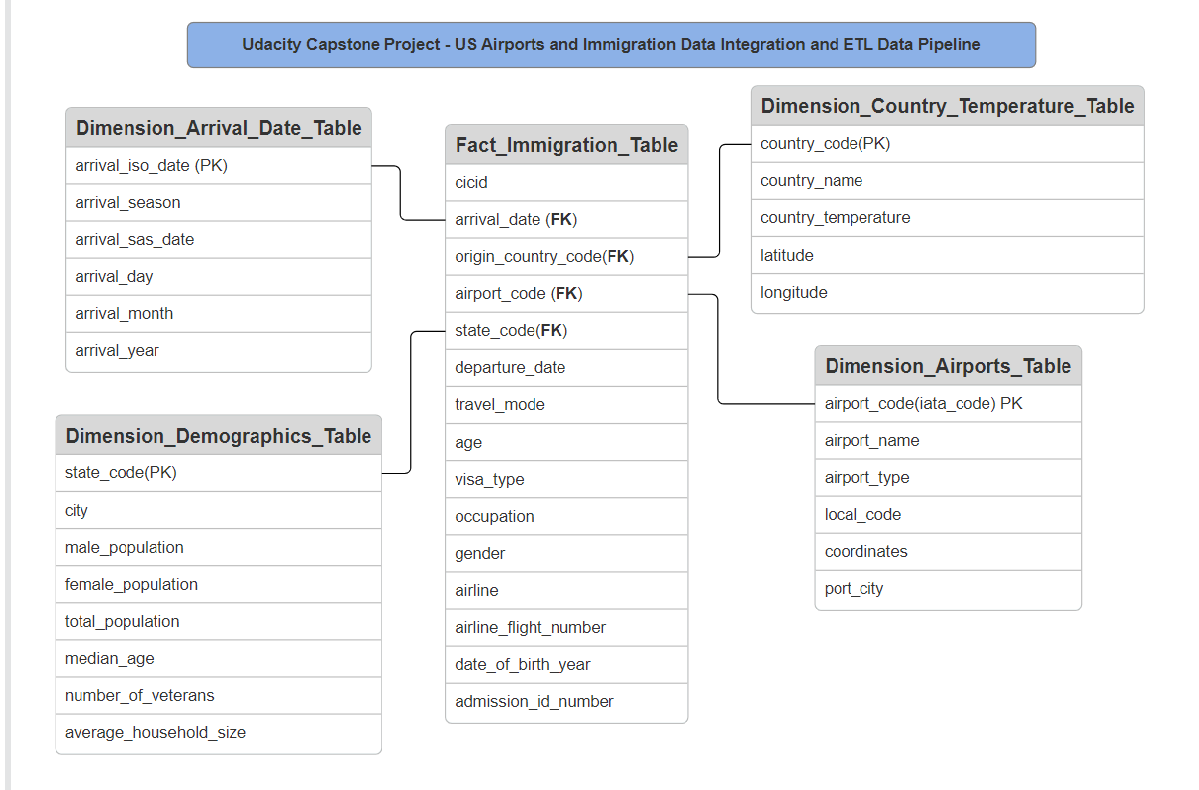

In [41]:
from IPython.display import Image

# Specify the path to your PNG file
image_path = "/kaggle/input/udacity-capstone-project-source-files/Conceptual_Data_Model.png"

# Display the image in the Jupyter Notebook cell
Image(filename=image_path)

#### Step 3.2 : Cleaning the data sets

In [42]:
# Converting the Arrival Date and Departure Date into the required YYYY-MM-DD date format
df_immigration_data['arrdate'] = pd.to_timedelta(df_immigration_data['arrdate'], unit='D') + pd.Timestamp('1960-1-1')
df_immigration_data['depdate'] = pd.to_timedelta(df_immigration_data['depdate'], unit='D') + pd.Timestamp('1960-1-1')

In [43]:
# Extracting the data columns for the FACT Immigration table 
fact_immigration_table = df_immigration_data[['cicid', 'arrdate', 'i94res', 'i94port', 'i94addr', 'depdate', 'i94mode', 'i94visa','visatype','occup','gender','airline','fltno','biryear','admnum']]

fact_immigration_table.columns = ['cic_id', 'arrive_date', 'origin_country_code', 'airport_code','state_code', 'departure_date', 'mode', 'visa','visa_type','occupation','gender','airline','airline_flight_number','date_of_birth_year','admission_id_number']

fact_immigration_table.head(8)

,cic_id,arrive_date,origin_country_code,airport_code,state_code,departure_date,mode,visa,visa_type,occupation,gender,airline,airline_flight_number,date_of_birth_year,admission_id_number
0,4084316.0,2016-04-22,209.0,HHW,HI,2016-04-29,1.0,2.0,WT,NaN,F,JL,00782,1955.0,5.658267e+10
1,4422636.0,2016-04-23,582.0,MCA,TX,2016-04-24,1.0,2.0,B2,NaN,M,*GA,XBLNG,1990.0,9.436200e+10
2,1195600.0,2016-04-07,112.0,OGG,FL,2016-04-27,1.0,2.0,WT,NaN,M,LH,00464,1940.0,5.578047e+10
3,5291768.0,2016-04-28,297.0,LOS,CA,2016-05-07,1.0,2.0,B2,NaN,M,QR,00739,1991.0,9.478970e+10
4,985523.0,2016-04-06,111.0,CHM,NY,2016-04-09,3.0,2.0,WT,NaN,F,NaN,LAND,1997.0,4.232257e+10
5,1481650.0,2016-04-08,577.0,ATL,GA,2016-06-01,1.0,2.0,B2,NaN,M,DL,910,1965.0,7.368526e+08
6,2197173.0,2016-04-12,245.0,SFR,CA,2016-06-30,1.0,2.0,B2,NaN,F,CX,870,1968.0,7.863122e+08
7,232708.0,2016-04-02,135.0,NYC,NY,2016-04-10,1.0,2.0,WT,NaN,F,BA,00117,1983.0,5.547449e+10


In [44]:
# Extracting the data columns for the DIMENSION Demographics Table

dimension_demographics_table = df_demographics_data[['State Code','City','Male Population','Female Population','Total Population','Median Age','Number of Veterans','Average Household Size','Count']]


dimension_demographics_table.columns = ['state_code','city','male_population','female_population','total_population','median_age','number_of_veterans','average_household_size','total_count']

dimension_demographics_table.head(5)

,state_code,city,male_population,female_population,total_population,median_age,number_of_veterans,average_household_size,total_count
0,MD,Silver Spring,40601.0,41862.0,82463,33.8,1562.0,2.60,25924
1,MA,Quincy,44129.0,49500.0,93629,41.0,4147.0,2.39,58723
2,AL,Hoover,38040.0,46799.0,84839,38.5,4819.0,2.58,4759
3,CA,Rancho Cucamonga,88127.0,87105.0,175232,34.5,5821.0,3.18,24437
4,NJ,Newark,138040.0,143873.0,281913,34.6,5829.0,2.73,76402


In [45]:
# Extracting the data columns for the DIMENSION Country Temperature Table

dimension_temp_countries_temperature_table = df_temperature_data[['dt','City','Country','AverageTemperature','Latitude','Longitude']]
dimension_temp_countries_temperature_table.columns = ['temperature_date','city','country','average_temperature','latitude','longitude']

dimension_temp_countries_temperature_table['country'] = dimension_temp_countries_temperature_table['country'].str.lower()
df_country_code['country_name'] = df_country_code['country_name'].str.lower()
                                                                                                   
#dimension_temp_countries_temperature_table.head()
#df_country_code.head()

dimension_countries_temperature_table = pd.merge(dimension_temp_countries_temperature_table, df_country_code, left_on='country', right_on='country_name', how='inner')

dimension_countries_temperature_table.head()

/tmp/ipykernel_42/2654625730.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dimension_temp_countries_temperature_table['country'] = dimension_temp_countries_temperature_table['country'].str.lower()


,temperature_date,city,country,average_temperature,latitude,longitude,country_code,country_name
0,1743-11-01,Århus,denmark,6.068,57.05N,10.33E,108,denmark
1,1743-12-01,Århus,denmark,NaN,57.05N,10.33E,108,denmark
2,1744-01-01,Århus,denmark,NaN,57.05N,10.33E,108,denmark
3,1744-02-01,Århus,denmark,NaN,57.05N,10.33E,108,denmark
4,1744-03-01,Århus,denmark,NaN,57.05N,10.33E,108,denmark


In [46]:
# Extracting the data columns for the DIMENSION Airports Table

dimension_airports_table = df_airports_code_data [['iata_code','name','type','local_code','coordinates']]

dimension_airports_table.columns = ['airport_code','airport_name','airport_type','local_code','coordinates']

dimension_airports_table.head(5)

,airport_code,airport_name,airport_type,local_code,coordinates
0,NaN,Total Rf Heliport,heliport,00A,"-74.93360137939453, 40.07080078125"
1,NaN,Aero B Ranch Airport,small_airport,00AA,"-101.473911, 38.704022"
2,NaN,Lowell Field,small_airport,00AK,"-151.695999146, 59.94919968"
3,NaN,Epps Airpark,small_airport,00AL,"-86.77030181884766, 34.86479949951172"
4,NaN,Newport Hospital & Clinic Heliport,closed,NaN,"-91.254898, 35.6087"


In [47]:
# Extracting the data columns for the DIMENSION Arrival Date Table

df_immigration_data['arrdate'] = pd.to_datetime(df_immigration_data['arrdate'])

# Create a copy of the DataFrame to avoid SettingWithCopyWarning
dimension_arrival_date_table = df_immigration_data[['arrdate']].copy()
dimension_arrival_date_table.columns = ['arrival_date']

# Convert 'arrival_date' to datetime format
dimension_arrival_date_table['arrival_date'] = pd.to_datetime(dimension_arrival_date_table['arrival_date'])

# Create new columns
dimension_arrival_date_table['arrival_iso_date'] = dimension_arrival_date_table['arrival_date'].dt.strftime('%G-%V-%u').astype(str)
dimension_arrival_date_table['arrival_season'] = dimension_arrival_date_table['arrival_date'].dt.quarter
dimension_arrival_date_table['arrival_sas_date'] = dimension_arrival_date_table['arrival_date'].dt.strftime('%Y%m%d')
dimension_arrival_date_table['arrival_day'] = dimension_arrival_date_table['arrival_date'].dt.day
dimension_arrival_date_table['arrival_month'] = dimension_arrival_date_table['arrival_date'].dt.month
dimension_arrival_date_table['arrival_year'] = dimension_arrival_date_table['arrival_date'].dt.year

# Display the DataFrame with new columns
dimension_arrival_date_table.head()

,arrival_date,arrival_iso_date,arrival_season,arrival_sas_date,arrival_day,arrival_month,arrival_year
0,2016-04-22,2016-16-5,2,20160422,22,4,2016
1,2016-04-23,2016-16-6,2,20160423,23,4,2016
2,2016-04-07,2016-14-4,2,20160407,7,4,2016
3,2016-04-28,2016-17-4,2,20160428,28,4,2016
4,2016-04-06,2016-14-3,2,20160406,6,4,2016


#### 3.2 Mapping Out Data Pipelines
###### List the steps necessary to pipeline the data into the chosen data model

1) All the following data sources are loaded into the respective datadrame using Pandas.

2) Data Assessment and Data Exploration was done using the various Pandas functions like info, shape, descibe etc. to get the descriptive statistics of the data columns in the dataframes.

3) Pre-processig data quality checks on all the dataframe has been performed e.g. finding duplicates, finding NULLs, NaNs, volumne count, data types etc. on the following 

4) Data Dictionary for all the data sources has been performed.

5) Conceptual Data model which STAR schema has been visualized clearly depicting the centralized FACT and surrounding DIMENSION tables for better understanding.

6) Cleaning steps has been performed on the data frames to get the cleaned and neat data set into the respective tables i.e.

    fact_immigration_table    
    dimension_arrival_date_table    
    dimension_airports_table    
    dimension_demographics_table    
    dimension_countries_temperature_table
    
    
 7) Using Spark SQL Fact and Dimension tables are joined to get the relevant dataset for Business Insights and Data Visualization

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [48]:
# Dataframes info for the Pandas dataframe created after defining the DATA model

In [49]:
fact_immigration_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   cic_id                 1000 non-null   float64       
 1   arrive_date            1000 non-null   datetime64[ns]
 2   origin_country_code    1000 non-null   float64       
 3   airport_code           1000 non-null   object        
 4   state_code             941 non-null    object        
 5   departure_date         951 non-null    datetime64[ns]
 6   mode                   1000 non-null   float64       
 7   visa                   1000 non-null   float64       
 8   visa_type              1000 non-null   object        
 9   occupation             4 non-null      object        
 10  gender                 859 non-null    object        
 11  airline                967 non-null    object        
 12  airline_flight_number  992 non-null    object        
 13  date

In [50]:
dimension_arrival_date_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   arrival_date      1000 non-null   datetime64[ns]
 1   arrival_iso_date  1000 non-null   object        
 2   arrival_season    1000 non-null   int32         
 3   arrival_sas_date  1000 non-null   object        
 4   arrival_day       1000 non-null   int32         
 5   arrival_month     1000 non-null   int32         
 6   arrival_year      1000 non-null   int32         
dtypes: datetime64[ns](1), int32(4), object(2)
memory usage: 39.2+ KB


In [51]:
dimension_airports_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55075 entries, 0 to 55074
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   airport_code  9189 non-null   object
 1   airport_name  55075 non-null  object
 2   airport_type  55075 non-null  object
 3   local_code    28686 non-null  object
 4   coordinates   55075 non-null  object
dtypes: object(5)
memory usage: 2.1+ MB


In [52]:
dimension_demographics_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891 entries, 0 to 2890
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state_code              2891 non-null   object 
 1   city                    2891 non-null   object 
 2   male_population         2888 non-null   float64
 3   female_population       2888 non-null   float64
 4   total_population        2891 non-null   int64  
 5   median_age              2891 non-null   float64
 6   number_of_veterans      2878 non-null   float64
 7   average_household_size  2875 non-null   float64
 8   total_count             2891 non-null   int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 203.4+ KB


In [53]:
dimension_countries_temperature_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6639096 entries, 0 to 6639095
Data columns (total 8 columns):
 #   Column               Dtype  
---  ------               -----  
 0   temperature_date     object 
 1   city                 object 
 2   country              object 
 3   average_temperature  float64
 4   latitude             object 
 5   longitude            object 
 6   country_code         object 
 7   country_name         object 
dtypes: float64(1), object(7)
memory usage: 405.2+ MB


In [54]:
# Creating the ETL pipeline for data model for Immigration data

# Creating Spark Session "Udacity_Capstone_US_Immigration_Project" 
spark = SparkSession.builder.appName("Udacity_Capstone_US_Immigration_Project").getOrCreate()

# Define the schema for the Spark DataFrame based on Pandas DataFrame
schema = StructType([
    StructField("cic_id", DoubleType(), True),
    StructField("arrive_date", DateType(), True),
    StructField("origin_country_code", DoubleType(), True),
    StructField("airport_code", StringType(), True),
    StructField("state_code", StringType(), True),
    StructField("departure_date", DateType(), True),
    StructField("mode", DoubleType(), True),
    StructField("visa", DoubleType(), True),
    StructField("visa_type", StringType(), True),
    StructField("occupation", StringType(), True),
    StructField("gender", StringType(), True),
    StructField("airline", StringType(), True),
    StructField("airline_flight_number", StringType(), True),
    StructField("date_of_birth_year", DoubleType(), True),
    StructField("admission_id_number", DoubleType(), True),
])

# Convert Pandas DataFrame to Spark DataFrame
spark_fact_immigration_table = spark.createDataFrame(fact_immigration_table, schema=schema)

# Create or replace a temporary view
spark_fact_immigration_table.createOrReplaceTempView("fact_immigration_table")

# Now we can use Spark SQL queries on the created view
result_fact_immigration = spark.sql("SELECT * FROM fact_immigration_table")
result_fact_immigration.show(3)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/29 04:35:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+---------+-----------+-------------------+------------+----------+--------------+----+----+---------+----------+------+-------+---------------------+------------------+-------------------+
|   cic_id|arrive_date|origin_country_code|airport_code|state_code|departure_date|mode|visa|visa_type|occupation|gender|airline|airline_flight_number|date_of_birth_year|admission_id_number|
+---------+-----------+-------------------+------------+----------+--------------+----+----+---------+----------+------+-------+---------------------+------------------+-------------------+
|4084316.0| 2016-04-22|              209.0|         HHW|        HI|    2016-04-29| 1.0| 2.0|       WT|       NaN|     F|     JL|                00782|            1955.0|    5.6582674633E10|
|4422636.0| 2016-04-23|              582.0|         MCA|        TX|    2016-04-24| 1.0| 2.0|       B2|       NaN|     M|    *GA|                XBLNG|            1990.0|     9.436199593E10|
|1195600.0| 2016-04-07|              112.0|       

In [55]:
# Define the schema for the Spark DataFrame for DIMENSION Arrival Date Table
schema = StructType([
    StructField("arrival_date", DateType(), True),
    StructField("arrival_iso_date", StringType(), True),
    StructField("arrival_season", IntegerType(), True),
    StructField("arrival_sas_date", StringType(), True),
    StructField("arrival_day", IntegerType(), True),
    StructField("arrival_month", IntegerType(), True),
    StructField("arrival_year", IntegerType(), True)
])

# Convert Pandas DataFrame to Spark DataFrame
spark_dimension_arrival_date_table = spark.createDataFrame(dimension_arrival_date_table, schema=schema)

# Create or replace a temporary view for Spark SQL queries
spark_dimension_arrival_date_table.createOrReplaceTempView("dimension_arrival_date_table")

# Now we can use Spark SQL queries on the "dimension_arrival_date_table" view
result_dimension_arrival_date = spark.sql("SELECT * FROM dimension_arrival_date_table")
result_dimension_arrival_date.show(2)

+------------+----------------+--------------+----------------+-----------+-------------+------------+
|arrival_date|arrival_iso_date|arrival_season|arrival_sas_date|arrival_day|arrival_month|arrival_year|
+------------+----------------+--------------+----------------+-----------+-------------+------------+
|  2016-04-22|       2016-16-5|             2|        20160422|         22|            4|        2016|
|  2016-04-23|       2016-16-6|             2|        20160423|         23|            4|        2016|
+------------+----------------+--------------+----------------+-----------+-------------+------------+
only showing top 2 rows



In [56]:
# Define the schema for the Spark DataFrame for DIMENSION Airports Table
schema = StructType([
    StructField("airport_code", StringType(), True),
    StructField("airport_name", StringType(), True),
    StructField("airport_type", StringType(), True),
    StructField("local_code", StringType(), True),
    StructField("coordinates", StringType(), True)
])

# Convert Pandas DataFrame to Spark DataFrame
spark_dimension_airports_table = spark.createDataFrame(dimension_airports_table, schema=schema)

# Create or replace a temporary view for Spark SQL queries
spark_dimension_airports_table.createOrReplaceTempView("dimension_airports_table")

# Now we can use Spark SQL queries on the "dimension_airports_table" view
result_dimension_airports = spark.sql("SELECT * FROM dimension_airports_table")
result_dimension_airports.show(2)

+------------+--------------------+-------------+----------+--------------------+
|airport_code|        airport_name| airport_type|local_code|         coordinates|
+------------+--------------------+-------------+----------+--------------------+
|         NaN|   Total Rf Heliport|     heliport|       00A|-74.9336013793945...|
|         NaN|Aero B Ranch Airport|small_airport|      00AA|-101.473911, 38.7...|
+------------+--------------------+-------------+----------+--------------------+
only showing top 2 rows



23/12/29 04:35:29 WARN TaskSetManager: Stage 2 contains a task of very large size (1060 KiB). The maximum recommended task size is 1000 KiB.


In [57]:
# Convert columns with decimal values to float before using the float columns
decimal_columns = ['male_population', 'female_population', 'number_of_veterans']
dimension_demographics_table[decimal_columns] = dimension_demographics_table[decimal_columns].astype(float)

# Define the schema for the Spark DataFrame for Dimension Demographics Table
schema = StructType([
    StructField("state_code", StringType(), True),
    StructField("city", StringType(), True),
    StructField("male_population", FloatType(), True),
    StructField("female_population", FloatType(), True),
    StructField("total_population", IntegerType(), True),
    StructField("median_age", FloatType(), True),
    StructField("number_of_veterans", FloatType(), True),
    StructField("average_household_size", FloatType(), True),
    StructField("total_count", IntegerType(), True)
])

# Convert Pandas DataFrame to Spark DataFrame
spark_dimension_demographics_table = spark.createDataFrame(dimension_demographics_table, schema=schema)

# Create or replace a temporary view for Spark SQL queries
spark_dimension_demographics_table.createOrReplaceTempView("dimension_demographics_table")

# Now we can use Spark SQL queries on the "dimension_demographics_table" view
result_dimension_demographics = spark.sql("SELECT * FROM dimension_demographics_table")
result_dimension_demographics.show(3)

/tmp/ipykernel_42/2928816481.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dimension_demographics_table[decimal_columns] = dimension_demographics_table[decimal_columns].astype(float)


+----------+-------------+---------------+-----------------+----------------+----------+------------------+----------------------+-----------+
|state_code|         city|male_population|female_population|total_population|median_age|number_of_veterans|average_household_size|total_count|
+----------+-------------+---------------+-----------------+----------------+----------+------------------+----------------------+-----------+
|        MD|Silver Spring|        40601.0|          41862.0|           82463|      33.8|            1562.0|                   2.6|      25924|
|        MA|       Quincy|        44129.0|          49500.0|           93629|      41.0|            4147.0|                  2.39|      58723|
|        AL|       Hoover|        38040.0|          46799.0|           84839|      38.5|            4819.0|                  2.58|       4759|
+----------+-------------+---------------+-----------------+----------------+----------+------------------+----------------------+-----------+

In [58]:
# Converting the temperature_date column to datetime
dimension_countries_temperature_table['temperature_date'] = pd.to_datetime(dimension_countries_temperature_table['temperature_date'])

# Define the schema for the Spark DataFrame
schema = StructType([
    StructField("temperature_date", StringType(), True),
    StructField("city", StringType(), True),
    StructField("country", StringType(), True),
    StructField("average_temperature", FloatType(), True),
    StructField("latitude", StringType(), True),
    StructField("longitude", StringType(), True),
    StructField("country_code", StringType(), True),
    StructField("country_name", StringType(), True)
])

# Convert Pandas DataFrame to Spark DataFrame
spark_dimension_countries_temperature_table = spark.createDataFrame(dimension_countries_temperature_table, schema=schema)

# Create or replace a temporary view for Spark SQL queries
spark_dimension_countries_temperature_table.createOrReplaceTempView("dimension_countries_temperature_table")

# Now we can use Spark SQL queries on the "dimension_countries_temperature_table" view
result_dimension_countries_temperature = spark.sql("SELECT country_code ,country_name, average_temperature,latitude, longitude FROM dimension_countries_temperature_table")
result_dimension_countries_temperature.show(2)

23/12/29 04:37:12 WARN TaskSetManager: Stage 4 contains a task of very large size (85451 KiB). The maximum recommended task size is 1000 KiB.


+------------+------------+-------------------+--------+---------+
|country_code|country_name|average_temperature|latitude|longitude|
+------------+------------+-------------------+--------+---------+
|         108|     denmark|              6.068|  57.05N|   10.33E|
|         108|     denmark|                NaN|  57.05N|   10.33E|
+------------+------------+-------------------+--------+---------+
only showing top 2 rows



23/12/29 04:37:16 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 4 (TID 4): Attempting to kill Python Worker


In [ ]:
# Output path for Parquet files
output_path = "/workspace/home/output_folder"

# Write Spark DataFrames to Parquet files
spark_fact_immigration_table.write.mode("overwrite").parquet(f"{output_path}/fact_immigration_table")
spark_dimension_arrival_date_table.write.mode("overwrite").parquet(f"{output_path}/dimension_arrival_date_table")
spark_dimension_airports_table.write.mode("overwrite").parquet(f"{output_path}/dimension_airports_table")
spark_dimension_demographics_table.write.mode("overwrite").parquet(f"{output_path}/dimension_demographics_table")
spark_dimension_countries_temperature_table.write.mode("overwrite").parquet(f"{output_path}/dimension_countries_temperature_table")

In [59]:
result_dimension_countries_temperature.printSchema()

root
 |-- country_code: string (nullable = true)
 |-- country_name: string (nullable = true)
 |-- average_temperature: float (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)



In [60]:
result_dimension_demographics.printSchema()

root
 |-- state_code: string (nullable = true)
 |-- city: string (nullable = true)
 |-- male_population: float (nullable = true)
 |-- female_population: float (nullable = true)
 |-- total_population: integer (nullable = true)
 |-- median_age: float (nullable = true)
 |-- number_of_veterans: float (nullable = true)
 |-- average_household_size: float (nullable = true)
 |-- total_count: integer (nullable = true)



In [61]:
result_dimension_airports.printSchema()

root
 |-- airport_code: string (nullable = true)
 |-- airport_name: string (nullable = true)
 |-- airport_type: string (nullable = true)
 |-- local_code: string (nullable = true)
 |-- coordinates: string (nullable = true)



In [62]:
result_dimension_arrival_date.printSchema()

root
 |-- arrival_date: date (nullable = true)
 |-- arrival_iso_date: string (nullable = true)
 |-- arrival_season: integer (nullable = true)
 |-- arrival_sas_date: string (nullable = true)
 |-- arrival_day: integer (nullable = true)
 |-- arrival_month: integer (nullable = true)
 |-- arrival_year: integer (nullable = true)



In [63]:
result_fact_immigration.printSchema()

root
 |-- cic_id: double (nullable = true)
 |-- arrive_date: date (nullable = true)
 |-- origin_country_code: double (nullable = true)
 |-- airport_code: string (nullable = true)
 |-- state_code: string (nullable = true)
 |-- departure_date: date (nullable = true)
 |-- mode: double (nullable = true)
 |-- visa: double (nullable = true)
 |-- visa_type: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- airline_flight_number: string (nullable = true)
 |-- date_of_birth_year: double (nullable = true)
 |-- admission_id_number: double (nullable = true)



In [64]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit

# Initialize Spark session with increased memory settings
spark = SparkSession.builder \
    .appName("DataQualityChecks") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

# Load the fact and dimension tables
dq_fact_immigration_table = spark.table("fact_immigration_table")
dq_dimension_arrival_date_table = spark.table("dimension_arrival_date_table")
dq_dimension_airports_table = spark.table("dimension_airports_table")
dq_dimension_demographics_table = spark.table("dimension_demographics_table")
#dq_dimension_countries_temperature_table = spark.table("dimension_countries_temperature_table")

# Data Quality Checks

# 1. Check for Missing Values
missing_values_check = lambda df, table_name: df.select([col(c).isNull().alias(c) for c in df.columns]) \
    .withColumn('table', lit(table_name)).limit(100)  # Adjust the limit as needed

# 2. Check Data Types
data_types_check = lambda df, table_name: df.select([col(c).cast("string").alias(c) for c in df.columns]) \
    .withColumn('table', lit(table_name)).limit(100)  # Adjust the limit as needed

# 3. Duplicate Records
duplicate_records_check = lambda df, table_name: df.groupBy(df.columns).count().filter(col("count") > 1) \
    .withColumn('table', lit(table_name)).limit(100)  # Adjust the limit as needed

# 4. Referential Integrity
referential_integrity_check = dq_fact_immigration_table.join(dq_dimension_arrival_date_table,
                                                             dq_fact_immigration_table["arrive_date"] == dq_dimension_arrival_date_table["arrival_date"], "left") \
    .filter(dq_dimension_arrival_date_table["arrival_date"].isNull()) \
    .withColumn('table', lit("fact_immigration_table")).limit(100)  # Adjust the limit as needed

# 5. Data Distribution
data_distribution_check = lambda df, column: df.groupBy(column).count() \
    .withColumn('table', lit(df.columns[0])).limit(100)  # Adjust the limit as needed

# Example: Check distribution of ages in demographics table
age_distribution_check = data_distribution_check(dq_dimension_demographics_table, "median_age")

# Execute Data Quality Checks
data_quality_checks_results = []

# Perform checks on each table
for table_df, table_name in [
    (dq_fact_immigration_table, "fact_immigration_table"),
    (dq_dimension_arrival_date_table, "dimension_arrival_date_table"),
    (dq_dimension_airports_table, "dimension_airports_table"),
    (dq_dimension_demographics_table, "dimension_demographics_table")
    #,(dq_dimension_countries_temperature_table, "dimension_countries_temperature_table")
]:
    # 1. Check for Missing Values
    missing_values_result = missing_values_check(table_df, table_name)
    data_quality_checks_results.append(missing_values_result)

    # 2. Check Data Types
    data_types_result = data_types_check(table_df, table_name)
    data_quality_checks_results.append(data_types_result)

    # 3. Duplicate Records
    duplicate_records_result = duplicate_records_check(table_df, table_name)
    data_quality_checks_results.append(duplicate_records_result)

# Display Results
for result_df in data_quality_checks_results:
    # Check if there are any issues before displaying
    if result_df.count() > 0:
        table_name = result_df.select('table').distinct().collect()[0]['table']
        print(f"Data Quality Checks passed for {table_name}:")
        result_df.show(5)

# Stop Spark session
spark.stop()


23/12/29 04:37:16 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Data Quality Checks passed for fact_immigration_table:
+------+-----------+-------------------+------------+----------+--------------+-----+-----+---------+----------+------+-------+---------------------+------------------+-------------------+--------------------+
|cic_id|arrive_date|origin_country_code|airport_code|state_code|departure_date| mode| visa|visa_type|occupation|gender|airline|airline_flight_number|date_of_birth_year|admission_id_number|               table|
+------+-----------+-------------------+------------+----------+--------------+-----+-----+---------+----------+------+-------+---------------------+------------------+-------------------+--------------------+
| false|      false|              false|       false|     false|         false|false|false|    false|     false| false|  false|                false|             false|              false|fact_immigration_...|
| false|      false|              false|       false|     false|         false|false|false|    false|    

Data Quality Checks passed for dimension_arrival_date_table:
+------------+----------------+--------------+----------------+-----------+-------------+------------+--------------------+
|arrival_date|arrival_iso_date|arrival_season|arrival_sas_date|arrival_day|arrival_month|arrival_year|               table|
+------------+----------------+--------------+----------------+-----------+-------------+------------+--------------------+
|       false|           false|         false|           false|      false|        false|       false|dimension_arrival...|
|       false|           false|         false|           false|      false|        false|       false|dimension_arrival...|
|       false|           false|         false|           false|      false|        false|       false|dimension_arrival...|
|       false|           false|         false|           false|      false|        false|       false|dimension_arrival...|
|       false|           false|         false|           false|      fa

Data Quality Checks passed for dimension_arrival_date_table:
+------------+----------------+--------------+----------------+-----------+-------------+------------+--------------------+
|arrival_date|arrival_iso_date|arrival_season|arrival_sas_date|arrival_day|arrival_month|arrival_year|               table|
+------------+----------------+--------------+----------------+-----------+-------------+------------+--------------------+
|  2016-04-22|       2016-16-5|             2|        20160422|         22|            4|        2016|dimension_arrival...|
|  2016-04-23|       2016-16-6|             2|        20160423|         23|            4|        2016|dimension_arrival...|
|  2016-04-07|       2016-14-4|             2|        20160407|          7|            4|        2016|dimension_arrival...|
|  2016-04-28|       2016-17-4|             2|        20160428|         28|            4|        2016|dimension_arrival...|
|  2016-04-06|       2016-14-3|             2|        20160406|        

Data Quality Checks passed for dimension_arrival_date_table:
+------------+----------------+--------------+----------------+-----------+-------------+------------+-----+--------------------+
|arrival_date|arrival_iso_date|arrival_season|arrival_sas_date|arrival_day|arrival_month|arrival_year|count|               table|
+------------+----------------+--------------+----------------+-----------+-------------+------------+-----+--------------------+
|  2016-04-21|       2016-16-4|             2|        20160421|         21|            4|        2016|   35|dimension_arrival...|
|  2016-04-19|       2016-16-2|             2|        20160419|         19|            4|        2016|   28|dimension_arrival...|
|  2016-04-26|       2016-17-2|             2|        20160426|         26|            4|        2016|   27|dimension_arrival...|
|  2016-04-04|       2016-14-1|             2|        20160404|          4|            4|        2016|   36|dimension_arrival...|
|  2016-04-30|       2016-17-

23/12/29 04:37:30 WARN TaskSetManager: Stage 54 contains a task of very large size (1060 KiB). The maximum recommended task size is 1000 KiB.
23/12/29 04:37:30 WARN TaskSetManager: Stage 57 contains a task of very large size (1060 KiB). The maximum recommended task size is 1000 KiB.
23/12/29 04:37:31 WARN TaskSetManager: Stage 60 contains a task of very large size (1060 KiB). The maximum recommended task size is 1000 KiB.


Data Quality Checks passed for dimension_airports_table:
+------------+------------+------------+----------+-----------+--------------------+
|airport_code|airport_name|airport_type|local_code|coordinates|               table|
+------------+------------+------------+----------+-----------+--------------------+
|       false|       false|       false|     false|      false|dimension_airport...|
|       false|       false|       false|     false|      false|dimension_airport...|
|       false|       false|       false|     false|      false|dimension_airport...|
|       false|       false|       false|     false|      false|dimension_airport...|
|       false|       false|       false|     false|      false|dimension_airport...|
+------------+------------+------------+----------+-----------+--------------------+
only showing top 5 rows



23/12/29 04:37:31 WARN TaskSetManager: Stage 61 contains a task of very large size (1060 KiB). The maximum recommended task size is 1000 KiB.
23/12/29 04:37:32 WARN TaskSetManager: Stage 64 contains a task of very large size (1060 KiB). The maximum recommended task size is 1000 KiB.
23/12/29 04:37:33 WARN TaskSetManager: Stage 67 contains a task of very large size (1060 KiB). The maximum recommended task size is 1000 KiB.


Data Quality Checks passed for dimension_airports_table:
+------------+--------------------+-------------+----------+--------------------+--------------------+
|airport_code|        airport_name| airport_type|local_code|         coordinates|               table|
+------------+--------------------+-------------+----------+--------------------+--------------------+
|         NaN|   Total Rf Heliport|     heliport|       00A|-74.9336013793945...|dimension_airport...|
|         NaN|Aero B Ranch Airport|small_airport|      00AA|-101.473911, 38.7...|dimension_airport...|
|         NaN|        Lowell Field|small_airport|      00AK|-151.695999146, 5...|dimension_airport...|
|         NaN|        Epps Airpark|small_airport|      00AL|-86.7703018188476...|dimension_airport...|
|         NaN|Newport Hospital ...|       closed|       NaN| -91.254898, 35.6087|dimension_airport...|
+------------+--------------------+-------------+----------+--------------------+--------------------+
only showing top

23/12/29 04:37:33 WARN TaskSetManager: Stage 68 contains a task of very large size (1060 KiB). The maximum recommended task size is 1000 KiB.
23/12/29 04:37:35 WARN TaskSetManager: Stage 74 contains a task of very large size (1060 KiB). The maximum recommended task size is 1000 KiB.
23/12/29 04:37:37 WARN TaskSetManager: Stage 80 contains a task of very large size (1060 KiB). The maximum recommended task size is 1000 KiB.


Data Quality Checks passed for dimension_airports_table:


+------------+--------------------+-------------+----------+--------------------+-----+--------------------+
|airport_code|        airport_name| airport_type|local_code|         coordinates|count|               table|
+------------+--------------------+-------------+----------+--------------------+-----+--------------------+
|         NaN|       Utai Airstrip|small_airport|      UTAI|    141.5868, -3.386|    2|dimension_airport...|
|         NaN|              delete|       closed|       NaN|                0, 0|    4|dimension_airport...|
|         NaN|    Fazenda Colorado|small_airport|       NaN|-44.799444, -9.25...|    3|dimension_airport...|
|         NaN|    Martin's Landing|small_airport|      CML5| -89.543002, 48.2936|    2|dimension_airport...|
|         RMD|Basanth Nagar Air...|small_airport|       NaN|     79.3923, 18.701|    2|dimension_airport...|
+------------+--------------------+-------------+----------+--------------------+-----+--------------------+
only showing top 5 

Data Quality Checks passed for dimension_demographics_table:
+----------+-----+---------------+-----------------+----------------+----------+------------------+----------------------+-----------+--------------------+
|state_code| city|male_population|female_population|total_population|median_age|number_of_veterans|average_household_size|total_count|               table|
+----------+-----+---------------+-----------------+----------------+----------+------------------+----------------------+-----------+--------------------+
|     false|false|          false|            false|           false|     false|             false|                 false|      false|dimension_demogra...|
|     false|false|          false|            false|           false|     false|             false|                 false|      false|dimension_demogra...|
|     false|false|          false|            false|           false|     false|             false|                 false|      false|dimension_demogra...|
|  

Data Quality Checks passed for dimension_demographics_table:
+----------+----------------+---------------+-----------------+----------------+----------+------------------+----------------------+-----------+--------------------+
|state_code|            city|male_population|female_population|total_population|median_age|number_of_veterans|average_household_size|total_count|               table|
+----------+----------------+---------------+-----------------+----------------+----------+------------------+----------------------+-----------+--------------------+
|        MD|   Silver Spring|        40601.0|          41862.0|           82463|      33.8|            1562.0|                   2.6|      25924|dimension_demogra...|
|        MA|          Quincy|        44129.0|          49500.0|           93629|      41.0|            4147.0|                  2.39|      58723|dimension_demogra...|
|        AL|          Hoover|        38040.0|          46799.0|           84839|      38.5|            4